To-do list: https://docs.google.com/document/d/1lLPy8CsYQXWQqpdLS9u5O1ga9l-3vCMluFO6sUckkts

### 연구 목적: Indoor moving patterns을 이용하여 revisit intention을 예측.

크롤링한 User들의 Wi-Fi log을, moving pattern별로 indexing한 후, 적합한 feature들을 선별하여, 어떤 moving pattern이 추후 customer revisit과 관련이 있는지 분석하고자 함.

#### Feature description:
특정 moving pattern의 revisit intention을 예측하는 supervised learning(classification) 모델에 이용될 feature들

**1. Feature 1 (History)**
    1. 해당 moving pattern이 일어난 시점까지 customer가 방문한 횟수: new_visit_count
**2. Feature 2-7 (Basic stats)**
    2. 해당 moving pattern에서 Wi-Fi에 연결된 area의 총 개수: num_logs
    3. 해당 moving pattern에서 Wi-Fi에 잡힌 총 시간(중복 포함 - 특정 시점에 다수의 Wi-Fi에 연결할 경우 시간을 모두 합함): total_dwell_time
    4. 해당 moving pattern에서 dwell_time > 100인 indoor area(stay point) 개수: num_sp_100
    5. 해당 moving pattern에서 customer가 방문한 indoor area의 총 개수 중에서 dwell_time > 100인 확률(방문한 area 중에서 stay point가 차지하는 비율): prob_dwell_100
    6. 해당 moving pattern에서 stay points에서 보낸 시간의 합(중복 포함 - 특정 시점에 다수의 Wi-Fi에 연결할 경우 시간을 모두 합함): time_sp_100
    7. 해당 moving pattern에서 dwell_time > 100인 indoor area들의 variance: std_sp_100
**3. Feature 8-14**
    8. 해당 moving pattern이 발생한 요일(Categorical variable): One-hot-encoding을 이용하여 Mon-Sun 7개의 feature(binary variable)로 표현
**4. Feature 15-137 (Trajectory)**
    9. Trajectory의 uni-gram, bi-gram features ('1f', '1f 1f', '1f 1f-inner', '1f 1f-left', '1f 1f-right', '1f 2f' ...) - 해당 moving pattern에 각 unigram 및 bigram이 몇 번 나왔는지 카운트


#### Details
1. Moving pattern: 한 유저가 하루 동안 매장 안에서 돌아다닌 와이파이 로그
2. Simple trajectory: Moving pattern에서 area를 시간 순서대로 나열한 sequence  (e.g., out,in,b1,b1-left-1,1f,out,in,b1-left)
2. Raw data의 경우 wi-fi에 찍힌 로그(어떤 device_id가 어떤 장소의 wi-fi 수신기에 몇시부터 몇초간 접속중이었고, 직원인지의 여부와, 현재까지의 revisit count와 가장 최근의 revisit interval)가 하나의 row로 이루어져 있다. 고로, 하나의 moving pattern에 대한 log가 여러 개로 이루어져 있는데, 로그의 날짜와 device_id를 조합하여 key로 삼고 aggregate하여 하나의 moving pattern이 하나의 row로 나타낼 수 있도록 함)
3. Raw data의 revisit_count 데이터를 보면 꼬인 경우가 많았다, 같은 device_id인데 오늘까지 revisit count가 69였는데 그다음날 7이 된다거나, 그래서 이 데이터를 이용하지 않고 새로 카운트해 주었다.
4. revisit_intention은 binary variable이며 우리가 예측하고자 하는 label이다, 매장 방문 이후 n일 (n=90) 이내에 다시 매장 방문 내역이 있다면 revisit_intention = 1 로 표시해 주었다.
5. 매장 방문의 정의: 특정 일에 특정 유저의 moving pattern이 out으로만 이루어진 로그가 아니면 매장을 방문하였다고 함. out만 여러번 있는 로그의 경우는 지나가는 행인이라고 생각하여 매장을 방문하지 않았다고 간주. (매장 방문 예시1: out,in,1f,1f-right  매장 방문 예시2: out,1f,1f-right,1f,out,2f,1f)
6. 따라서 어떤 유저의 timestamp가 가장 오래 된 방문을 가장 첫 방문이라고 가정하고, 그 다음 매장 방문이 발생하면 revisit_count를 1씩 더해 주었다, 이 때 각 방문 사이의 간격은 적어도 1일 이상이다. revisit_count는 각 방문 패턴의 history 정보를 누락시키지 않는다는 목적으로 feature로 삼기로 했다.
7. 참고: User-ID별로 indexing해서 유저별 revisit_count를 naive하게 예측한 이전 모델은 supervised_model(basic_features).ipynb 에 정리

#### 데이터
1. 786번 매장(코오롱 문정직영점) 데이터
    1. 직원이라고 한번이라도 로그에 찍힌 device_id는 제거
    2. 자주 방문하는 유저(단골 or 택배기사)의 moving pattern을 고려하지 않기 위해, 재방문 횟수가 3번 이하인 유저의 moving pattern만 분석
    3. 각 moving pattern별로 재인덱싱 이후 세어본 정식매장 방문 횟수(traj에 in을 포함한 경우) 22,642개(0: 19,953 vs 1: 2,689, revisit_intention 여부) 
    4. 위 데이터의 revisit intention label 비율을 50:50로 조절한 총 5,378개(0: 2,689 vs 1: 2,689)의 moving patterns을 최종으로 이용함.

####  Preliminary results
<pre>
* 10-fold CV 결과의 평균값 (샘플링 결과에 따라 변화가 있는데, 샘플링을 고려한 반복 실험 결과는 아래 boxplot을 참고)
    Accuracy
      * 3 Nearest Neighbors 0.518
      * Decision Tree 0.617
      * Random Forest 0.595
      * AdaBoost 0.622
      * Naive Bayes 0.567
      * Logistic Regression 0.583
    Precision
      * 3 Nearest Neighbors 0.519
      * Decision Tree 0.626
      * Random Forest 0.618
      * AdaBoost 0.643
      * Naive Bayes 0.64
      * Logistic Regression 0.596
    Recall
      * 3 Nearest Neighbors 0.512
      * Decision Tree 0.586
      * Random Forest 0.519
      * AdaBoost 0.55
      * Naive Bayes 0.308
      * Logistic Regression 0.514
    F1
      * 3 Nearest Neighbors 0.515
      * Decision Tree 0.604
      * Random Forest 0.583
      * AdaBoost 0.592
      * Naive Bayes 0.416
      * Logistic Regression 0.552
    ROC-AUC
      * 3 Nearest Neighbors 0.52
      * Decision Tree 0.65
      * Random Forest 0.636
      * AdaBoost 0.659
      * Naive Bayes 0.608
      * Logistic Regression 0.608
</pre>

In [43]:
### import libraries
import pandas as pd
import datetime
import numpy as np
import re

In [44]:
### 각 moving pattern별로 재인덱싱한 데이터 로드
trajs_combined = pd.read_pickle("../data/786/786_trajs_combined.p")

In [45]:
print(trajs_combined.shape)
trajs_combined.head(5)

(22642, 18)


,date,device_id,traj,new_visit_count,num_logs,total_dwell_time,num_sp_100,prob_dwell_100,time_sp_100,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,revisit_intention
16675_02614c7588f7f8eaa0d3b9047ac08410,16675.0,02614c7588f7f8eaa0d3b9047ac08410,"out,in,1f,1f-right,2f-left,2f,2f-right",1.0,7,1267,3.0,0.500000,354.0,10.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_028a1f4dbca00ed06814fdda60f1b599,16675.0,028a1f4dbca00ed06814fdda60f1b599,"out,in,3f,2f,2f-right,2f-inner,2f-left,1f,1f-r...",1.0,11,7139,7.0,0.700000,3553.0,362.141251,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_062c73a8b307fd05f6af2472a35671ef,16675.0,062c73a8b307fd05f6af2472a35671ef,"out,in,1f,1f-inner",1.0,4,2189,2.0,0.666667,1130.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_06c041f68ec481883941d47d99d6903f,16675.0,06c041f68ec481883941d47d99d6903f,"out,in,3f,in,1f,out",1.0,6,4259,4.0,1.000000,1286.0,159.307878,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16675_0a47ed78e921824cf54dddcf49ae2911,16675.0,0a47ed78e921824cf54dddcf49ae2911,"out,in",1.0,2,2636,1.0,1.000000,457.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Revisit intention이 있는 경우와 없는 경우 모두 비슷한 trajectories를 가지고 있어서, history를 고려하지 않는다고 할 때, indoor moving pattern만으로 classification이 가능할 지 걱정이 된다 (아래 참고)

In [46]:
### 어떤 trajectories가 있나 확인 (revisit_intention == 1인 경우)
print('Top 10 trajectories with revisit intention in 3 months\n', trajs_combined.loc[trajs_combined['revisit_intention'] == 1]['traj'].value_counts().head(10))
print(' ')
### 어떤 trajectories가 있나 확인 (revisit_intention == 0인 경우)
print('Top 10 trajectories with no revisit intention in 3 months\n', trajs_combined.loc[trajs_combined['revisit_intention'] == 0]['traj'].value_counts().head(10))

Top 10 trajectories with revisit intention in 3 months
 out,in,1f             335
out,in                228
out,in,2f              92
out,in,1f,1f-right     78
out,in,1f,out          69
out,out,in,1f          59
out,in,1f-right,1f     47
out,out,in             40
out,in,out             38
out,in,1f,1f-inner     32
Name: traj, dtype: int64
 
Top 10 trajectories with no revisit intention in 3 months
 out,in,1f             3078
out,in                2196
out,in,2f              794
out,in,1f,out          663
out,in,1f,1f-right     624
out,out,in,1f          565
out,in,out             446
out,out,in             435
out,in,1f-right,1f     296
out,in,1f,1f-inner     290
Name: traj, dtype: int64


1.0    16036
2.0     1932
3.0      914
Name: new_visit_count, dtype: int64


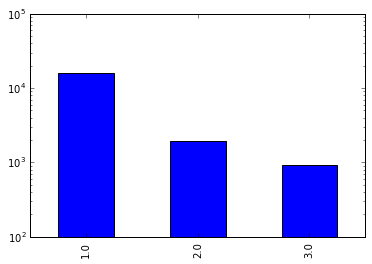

In [47]:
# 재방문 횟수별 사람 수
customer_revisit_count = trajs_combined.groupby(['device_id'])['new_visit_count'].max().value_counts().sort_index()
print (customer_revisit_count)

%matplotlib inline 
customer_revisit_count.plot(kind='bar', logy=True)

우리가 알고 싶은 방문객의 방문 횟수 범위는 3번 이하였다. 원본 데이터의 방문 횟수는 아래와 같다
![](2016-09-18_10.07.01.png)

### Final data preprocessing
라벨 비율 맞추기

In [161]:
## Revisit intention 비율을 50대 50으로 맞춤 (sampling)
# trajs_combined = trajs_combined.loc[trajs_combined['prob_deny']==0]
def balancing(trajs_combined):
    trajs_1 = trajs_combined.loc[trajs_combined['revisit_intention']==1]
    trajs_0 = trajs_combined.loc[trajs_combined['revisit_intention']==0]

    new_trajs_0 = trajs_0.iloc[np.random.permutation(len(trajs_0))][:trajs_1.shape[0]]  ## trajs_1의 크기에 맞게 trajs_0을 랜덤 샘플링.

    # 1:1 비율의 dataframe 만들기
    trajs_combined_balanced = pd.concat([trajs_1, new_trajs_0])
    trajs_combined_balanced = trajs_combined_balanced.sample(frac=1)  ## reshuffle after concatenation

#     print(trajs_1.shape)
#     print(trajs_0.shape)
#     print(trajs_combined_balanced.shape) ## 이용할 데이터
    return trajs_combined_balanced

trajs_combined_balanced = balancing(trajs_combined)

In [159]:
df_learning = trajs_combined_balanced
df_learning = df_learning.fillna(0)
df_learning = df_learning.reindex(np.random.permutation(df_learning.index))
df_learning.tail(5)

,date,device_id,traj,new_visit_count,num_logs,total_dwell_time,num_sp_100,prob_dwell_100,time_sp_100,std_sp_100,Fri,Mon,Sat,Sun,Thu,Tue,Wed,revisit_intention
16760_0d4ddf93b8bc9fc11e727865e02351ef,16760.0,0d4ddf93b8bc9fc11e727865e02351ef,"out,in,1f",1.0,3,4214,2.0,1.0,1328.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16811_532e1ee8aff9231db8feb9e2cc0f7a72,16811.0,532e1ee8aff9231db8feb9e2cc0f7a72,"out,in,1f",1.0,3,1454,2.0,1.0,512.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16716_ae2e3efee17983808b5ccc6f9cff2b73,16716.0,ae2e3efee17983808b5ccc6f9cff2b73,"out,in,2f-right,2f,1f",2.0,5,68,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
16791_b49a8debc8537eb5bfe80306f7cc9b18,16791.0,b49a8debc8537eb5bfe80306f7cc9b18,"out,in",1.0,2,255,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16677_8f7cf76e54bd832010f91b7b78d17ba2,16677.0,8f7cf76e54bd832010f91b7b78d17ba2,"out,in,1f,1f-right,1f-inner,1f-left,2f,1f,1f-r...",1.0,11,8793,9.0,0.9,6615.0,709.224048,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [78]:
### DataFame to nparray, divide features and labels
data = np.asarray(df_learning)
X_small, y = data[:, 3:-1], data[:, -1].astype(int)

### Add some trajectory features (Uni-gram, Bi-gram)

In [79]:
from sklearn.feature_extraction.text import CountVectorizer
bigram_vectorizer = CountVectorizer(min_df=1, token_pattern='\w+\-*\w+', ngram_range=(1, 2))

### Test with toy example
analyze = bigram_vectorizer.build_analyzer()
print(analyze('Bi-grams are cool!') == (['bi-grams', 'are', 'cool', 'bi-grams are', 'are cool']))

### Trajecory를 이용하여 bi-gram 생성 후 각 moving pattern별로 count
corpus = trajs_combined_balanced['traj']
corpvec2 = bigram_vectorizer.fit_transform(corpus)
print(corpvec2.toarray())
corpvec2

X = np.concatenate((X_small, corpvec2.toarray()), axis=1)
newcolumns = df_learning.columns.tolist()[:-1]+bigram_vectorizer.get_feature_names()
print(newcolumns)
print(X.shape)

True
[[1 0 0 ..., 1 1 0]
 [1 0 0 ..., 1 1 0]
 [0 0 0 ..., 2 1 0]
 ..., 
 [0 0 0 ..., 1 1 0]
 [0 0 0 ..., 2 1 1]
 [1 0 0 ..., 1 1 0]]
['date', 'device_id', 'traj', 'new_visit_count', 'num_logs', 'total_dwell_time', 'num_sp_100', 'prob_dwell_100', 'time_sp_100', 'std_sp_100', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '1f', '1f 1f', '1f 1f-inner', '1f 1f-left', '1f 1f-right', '1f 2f', '1f 2f-inner', '1f 2f-left', '1f 2f-right', '1f 3f', '1f in', '1f out', '1f-inner', '1f-inner 1f', '1f-inner 1f-inner', '1f-inner 1f-left', '1f-inner 1f-right', '1f-inner 2f', '1f-inner 2f-inner', '1f-inner 2f-left', '1f-inner 2f-right', '1f-inner 3f', '1f-inner in', '1f-inner out', '1f-left', '1f-left 1f', '1f-left 1f-inner', '1f-left 1f-left', '1f-left 1f-right', '1f-left 2f', '1f-left 2f-inner', '1f-left 2f-left', '1f-left 2f-right', '1f-left 3f', '1f-left in', '1f-left out', '1f-right', '1f-right 1f', '1f-right 1f-inner', '1f-right 1f-left', '1f-right 1f-right', '1f-right 2f', '1f-right 2f-inner',

## Analysis with sklearn classifiers

### Decision tree
* Decision tree: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* Cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html
* Adjusting different scoring parameters: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [80]:
print("Features", X_small[1:5])
print("Labels", y[1:5])

Features [[1.0 5 9403 4.0 1.0 5744.0 996.0003346719652 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 [1.0 6 344 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0]
 [1.0 4 4685 2.0 1.0 906.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0]
 [1.0 6 3604 4.0 0.8 2466.0 125.12793453102309 0.0 0.0 1.0 0.0 0.0 0.0 0.0]]
Labels [1 0 1 0]


In [155]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier(max_depth=5)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print('Decision tree')
for criteria in scoring:
    score = cross_val_score(clf, X, y, cv=10, scoring=criteria)  ## accuracy
    avgscore = score.sum()/len(score)
    print('  *', criteria, round(avgscore,3))

Decision tree
  * accuracy 0.613
  * precision 0.624
  * recall 0.576
  * f1 0.598
  * roc_auc 0.647


Feature ranking:
1. feature 1: new_visit_count (0.530494)
2. feature 6: time_sp_100 (0.303475)
3. feature 3: total_dwell_time (0.052346)
4. feature 11: Sun (0.029586)
5. feature 8: Fri (0.016562)
6. feature 137: out out (0.013155)
7. feature 2: num_logs (0.011446)
8. feature 128: in 2f (0.011224)
9. feature 123: in (0.010288)
10. feature 19: 1f 1f-right (0.009431)
11. feature 5: prob_dwell_100 (0.006834)
12. feature 62: 1f-right out (0.005160)
13. feature 42: 1f-left 1f-left (0.000000)
14. feature 47: 1f-left 2f-right (0.000000)


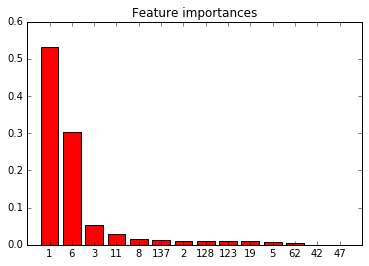

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline 

clf.fit(X,y)
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


numShow = X_small.shape[1]
for f in range(numShow):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f]+1, newcolumns[indices[f]+3], importances[indices[f]]))


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", align="center")
# plt.xticks(range(X.shape[1]), indices+1)
# plt.xlim([-1, X.shape[1]])
plt.bar(range(numShow), importances[indices][:numShow], color="r", align="center")  # Just plot top 15 features
plt.xticks(range(numShow), indices+1)
plt.xlim([-1, numShow])
plt.show()

In [84]:
X_top10 = X[:, [0,5,2,10,7,136,1,127,122,18]]

In [151]:
# Top feature 10개로만 진행
print(X_top10.shape)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

print('Decision tree')
for criteria in scoring:
    score = cross_val_score(clf, X_top10, y, cv=10, scoring=criteria)  ## accuracy
    avgscore = score.sum()/len(score)
    print('  *', criteria, round(avgscore,3))

(5378, 10)
Decision tree
  * accuracy 0.592
  * precision 0.604
  * recall 0.537
  * f1 0.568
  * roc_auc 0.613


In [152]:
# Basic feature만 가지고 테스트
X_first7 = X[:, 0:7]
for criteria in scoring:
    score = cross_val_score(clf, X_first7, y, cv=10, scoring=criteria)  ## accuracy
    avgscore = score.sum()/len(score)
    print('  *', criteria, round(avgscore,3))

  * accuracy 0.577
  * precision 0.596
  * recall 0.475
  * f1 0.528
  * roc_auc 0.602


In [153]:
# Basic feature - history(지금까지 방문 횟수) 제거 
X_2_7 = X[:, 1:7]
for criteria in scoring:
    score = cross_val_score(clf, X_2_7, y, cv=10, scoring=criteria)  ## accuracy
    avgscore = score.sum()/len(score)
    print('  *', criteria, round(avgscore,3))

  * accuracy 0.569
  * precision 0.592
  * recall 0.447
  * f1 0.509
  * roc_auc 0.583


### Comparison between classifiers

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [91]:
names = ["3 Nearest Neighbors",  "Decision Tree",
         "Random Forest", "AdaBoost",
         "Naive Bayes", "Logistic Regression"
        ]  ## "Linear SVM", "RBF SVM", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis"
classifiers = [
    KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),  ## very slow (can't wait)  
#     SVC(gamma=2, C=1), ## very slow (can't wait)
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
#     LinearDiscriminantAnalysis(),
    LogisticRegression(penalty='l2', class_weight='balanced', solver='liblinear')
    ]

In [154]:
for criteria in scoring:
    print('Scoring criteria:', criteria)
    for name, clf in zip(names, classifiers):
        score = cross_val_score(clf, X_small, y, cv=10, scoring=criteria)
        avgscore = score.sum()/len(score)
        print('  *', name, round(avgscore,3))

Scoring criteria: accuracy
  * 3 Nearest Neighbors 0.518
  * Decision Tree 0.617
  * Random Forest 0.595
  * AdaBoost 0.622
  * Naive Bayes 0.567
  * Logistic Regression 0.583
Scoring criteria: precision
  * 3 Nearest Neighbors 0.519
  * Decision Tree 0.626
  * Random Forest 0.618
  * AdaBoost 0.643
  * Naive Bayes 0.64
  * Logistic Regression 0.596
Scoring criteria: recall
  * 3 Nearest Neighbors 0.512
  * Decision Tree 0.586
  * Random Forest 0.519
  * AdaBoost 0.55
  * Naive Bayes 0.308
  * Logistic Regression 0.514
Scoring criteria: f1
  * 3 Nearest Neighbors 0.515
  * Decision Tree 0.604
  * Random Forest 0.583
  * AdaBoost 0.592
  * Naive Bayes 0.416
  * Logistic Regression 0.552
Scoring criteria: roc_auc
  * 3 Nearest Neighbors 0.52
  * Decision Tree 0.65
  * Random Forest 0.636
  * AdaBoost 0.659
  * Naive Bayes 0.608
  * Logistic Regression 0.608


### Sampling마다 결과가 변하므로 반복실험

Revisit-intention이 있는 Moving pattern(2,689개)와 Revisit-intention이 없는 Moving pattern(19,953개)의 개수 차이가 커서, 1:1로 라벨 비율을 맞추기 위하여 샘플링을(2,689개씩) 하는데, 샘플링 결과에 따라 classifier(decision tree)의 최종 prediction accuracy가 0.60-0.65 사이에서 변동하는 것을 관측하여 아래 실행을 진행함. 

샘플링 과정을 100번 한 후 각각의 샘플된 데이터에 대해 prediction 진행(10-fold cross validation)을 하여 Box-plot을 그림
1. 6개의 classifier를 이용
    * Logistic Regression
    * Random Forest
    * 3 Nearest Neighbors
    * Decision Tree
    * AdaBoost
    * Naive Bayes
2. 5개의 scoring criteria
    * accuracy
    * precision
    * recall
    * f1
    * roc_auc
    

In [179]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

bigram_vectorizer = CountVectorizer(min_df=1, token_pattern='\w+\-*\w+', ngram_range=(1, 2))
results_dict = dict()

for i in range(100):
    trajs_combined_balanced = balancing(trajs_combined)
    df_learning = trajs_combined_balanced
    df_learning = df_learning.fillna(0)
    df_learning = df_learning.reindex(np.random.permutation(df_learning.index))
    df_learning.tail(5)
    data = np.asarray(df_learning)
    X_small, y = data[:, 3:-1], data[:, -1].astype(int)

    corpus = trajs_combined_balanced['traj']
    corpvec2 = bigram_vectorizer.fit_transform(corpus)

    X = np.concatenate((X_small, corpvec2.toarray()), axis=1)
    newcolumns = df_learning.columns.tolist()[:-1]+bigram_vectorizer.get_feature_names()

    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    
    for name, clf in zip(names, classifiers):
        results_dict.setdefault(name, dict())
        for criteria in scoring:
            score = cross_val_score(clf, X, y, cv=10, scoring=criteria)
            avgscore = score.sum()/len(score)
#             print('  *', name, criteria, round(avgscore,3))
            results_dict[name].setdefault(criteria, []).append(avgscore)

In [181]:
import pickle
with open('preliminary_results_160918_sample.pickle', 'wb') as handle:
  pickle.dump(results_dict, handle)

In [182]:
from collections import OrderedDict
with open('preliminary_results_160918_sample.pickle', 'rb') as handle:
  b = pickle.load(handle)

In [ ]:
import numpy as np
np.random.seed(937)
labels = ['r', 'f1', 'p', 'a', 'auc']
fs = 10 # fontsize
# demonstrate how to toggle the display of different elements:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,6))
idx1 = 0
for classifier in b.keys():
    print(classifier)
    data = np.array(list(b[classifier].values())).T
    axes[idx1].boxplot(data, labels=labels)
    axes[idx1].set_ylim(0.3, 0.7)
    axes[idx1].set_title(classifier, fontsize=fs)
    idx1 += 1

Logistic Regression
Random Forest
3 Nearest Neighbors
Decision Tree
AdaBoost
Naive Bayes


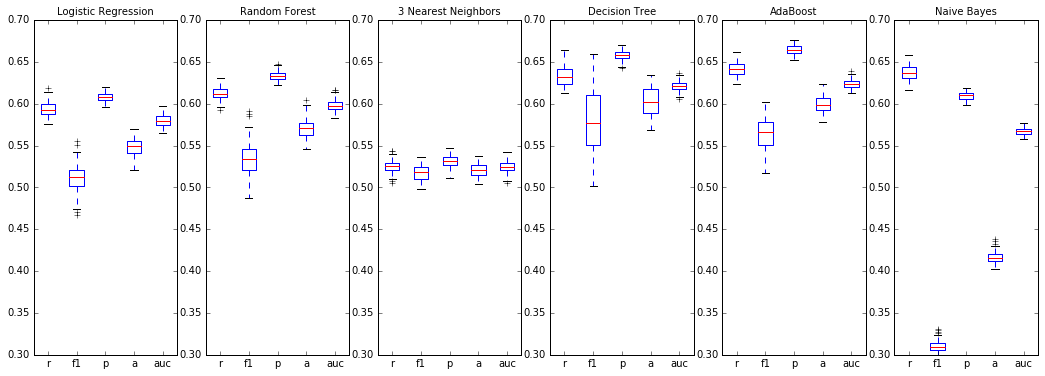

In [183]:
labels = ['r', 'f1', 'p', 'a', 'auc']
fs = 10 # fontsize
# demonstrate how to toggle the display of different elements:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18,6))
idx1 = 0
for classifier in b.keys():
    print(classifier)
    data = np.array(list(b[classifier].values())).T
    axes[idx1].boxplot(data, labels=labels)
    axes[idx1].set_ylim(0.3, 0.7)
    axes[idx1].set_title(classifier, fontsize=fs)
    idx1 += 1

In [184]:
c = {}
for key in b['3 Nearest Neighbors'].keys():
    c[key] = {}

for i in b.keys():
    for j in b[i].keys():    
        c[j][i] = b[i][j]

precision
recall
roc_auc
f1
accuracy


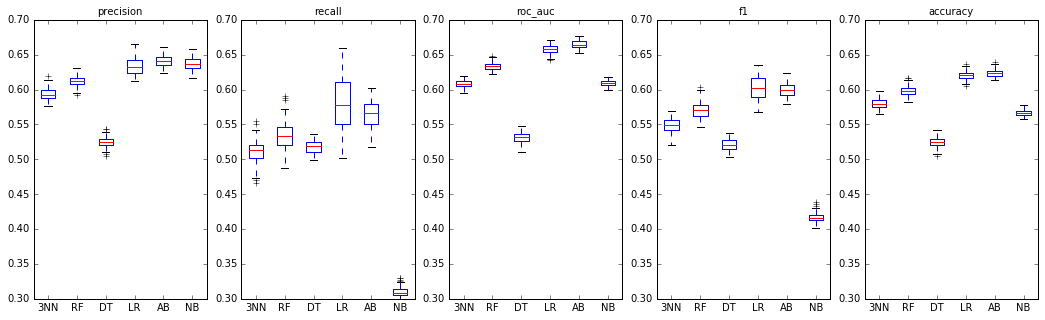

In [185]:
labels = ['3NN', 'RF', 'DT', 'LR', 'AB', 'NB']
fs = 10 # fontsize
# demonstrate how to toggle the display of different elements:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18,5))
idx1 = 0
for criteria in c.keys():
    print(criteria)
    data = np.array(list(c[criteria].values())).T
    axes[idx1].boxplot(data, labels=labels)
    axes[idx1].set_ylim(0.3, 0.7)
    axes[idx1].set_title(criteria, fontsize=fs)
    idx1 += 1

### Feature 전체 사용 vs 일부 사용 결과

1. 데이터 분류
    1. X: 기본 통계 feature 7개 + 요일 feature 7개 + trajectory uni,bigram 123개 = 137개
    2. X_small: 기본 통계 feature 7개 + 요일 feature 7개 = 14개
    3. X_basic: 기본 통계 feature 7개 = 7개
    4. X_top10: X에서 중요도 순으로 뽑은 10개 feature (각 샘플링 때마다 변화가 있다)

Feature를 어떻게 택하느냐에 따라 달라지는 예측 결과에 대한 boxplot.
앞선 실험과 같이 샘플링 에러를 없애기 위해, feature importance가 나오는 3개의 classifier를 5개의 scoring criteria에 대해 100번 반복한 실험 결과이다.
137개 feature를 다 사용하였을 때 예측 결과가 잘 나올 거라고 생각하기 쉬운데, 눈으로 예측 결과물을 본 결과 정확도가 오히려 떨어질 수도 있다는 점을 발견하였고, 이를 증명하는 아래 boxplot은 아무리 trajectory feature를 추가하였다 할지라도, feature를 개수가 예측 결과의 정확도를 guarantee하지 않음을 나타내 준다. 오히려 simple statistics 7가지만 이용한 X_basic이 가장 좋은 결과를 나타내는 경우도 있다.

In [200]:
names = ["Decision Tree",
         "Random Forest", "AdaBoost"
        ]  ## "Linear SVM", "RBF SVM", "Linear Discriminant Analysis", "Quadratic Discriminant Analysis"
classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()
    ]

In [225]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

bigram_vectorizer = CountVectorizer(min_df=1, token_pattern='\w+\-*\w+', ngram_range=(1, 2))
results_dict2 = dict()

for i in range(100):
    trajs_combined_balanced = balancing(trajs_combined)
    df_learning = trajs_combined_balanced
    df_learning = df_learning.fillna(0)
    df_learning = df_learning.reindex(np.random.permutation(df_learning.index))
    df_learning.tail(5)
    data = np.asarray(df_learning)
    X_small, X_basic, y = data[:, 3:-1], data[:,3:10], data[:, -1].astype(int)
    corpus = trajs_combined_balanced['traj']
    corpvec2 = bigram_vectorizer.fit_transform(corpus)

    X = np.concatenate((X_small, corpvec2.toarray()), axis=1)
    newcolumns = df_learning.columns.tolist()[:-1]+bigram_vectorizer.get_feature_names()
    
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    
    for name, clf in zip(names, classifiers):
        results_dict2.setdefault(name, dict())
        
        clf.fit(X, y)
        importances = clf.feature_importances_
        indices = np.argsort(importances)[::-1]
        X_top10 = X[:,indices[:10]]
        
        for inputX in ['X', 'X_small', 'X_basic', 'X_top10']:
            results_dict2[name].setdefault(inputX, dict())
            
            
        for criteria in scoring:

            score1 = cross_val_score(clf, X, y, cv=10, scoring=criteria)
            avgscore1 = score1.sum()/len(score1)
            results_dict2[name]['X'].setdefault(criteria, []).append(avgscore1)

            score2 = cross_val_score(clf, X_small, y, cv=10, scoring=criteria)
            avgscore2 = score2.sum()/len(score)
            results_dict2[name]['X_small'].setdefault(criteria, []).append(avgscore2)

            score3 = cross_val_score(clf, X_basic, y, cv=10, scoring=criteria )
            avgscore3 = score3.sum()/len(score)
            results_dict2[name]['X_basic'].setdefault(criteria, []).append(avgscore3)
            
            score4 = cross_val_score(clf, X_top10, y, cv=10, scoring=criteria )
            avgscore4 = score4.sum()/len(score)
            results_dict2[name]['X_top10'].setdefault(criteria, []).append(avgscore4)
#             print('  *', name, criteria, round(avgscore4,3))

In [232]:
with open('preliminary_results_features_160918_sample.pickle', 'wb') as handle:
  pickle.dump(results_dict2, handle)

In [233]:
from collections import OrderedDict
with open('preliminary_results_features_160918_sample.pickle', 'rb') as handle:
  b2 = pickle.load(handle)

In [297]:
from collections import defaultdict

def nestdicflip(data):
    flipped = defaultdict(dict)
    for key, val in data.items():
        for subkey, subval in val.items():
            flipped[subkey][key] = subval
    return dict(flipped)

In [303]:
c2['accuracy'].keys()

dict_keys(['X_small', 'X_top10', 'X_basic', 'X'])

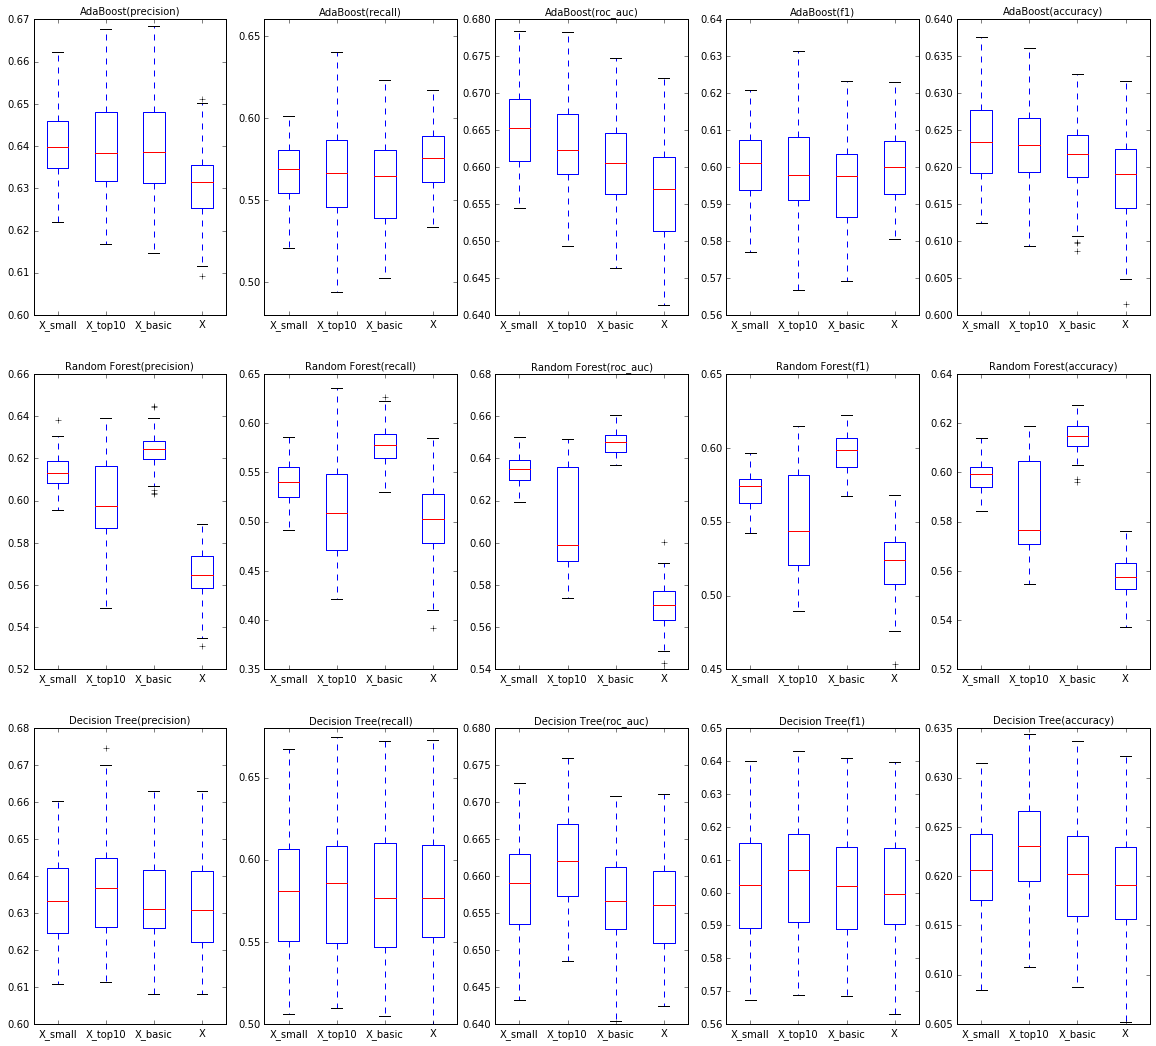

In [351]:
fs = 10 # fontsize
# demonstrate how to toggle the display of different elements:
nk = len(b2.keys())
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20,6*nk))
idx2 = 0

for classifier in b2.keys():
    c2 = nestdicflip(b2[classifier])
    idx1 = 0
    for criteria in c2.keys():
        labels = c2[criteria].keys()
        data = np.array(list(c2[criteria].values())).T
        axes[idx2, idx1].boxplot(data, labels=labels)
    #     axes[idx1].set_ylim(0.61, 0.63)
        axes[idx2, idx1].set_title(classifier+"("+criteria+")", fontsize=fs)
        idx1 += 1
    idx2 += 1
    
fig.savefig('foo.png', dpi=400)

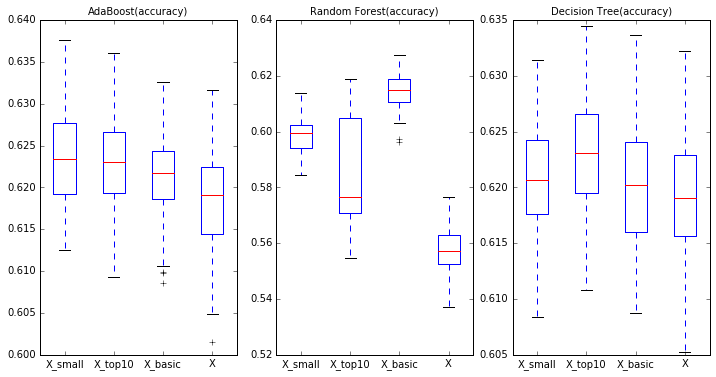

In [353]:
fs = 10 # fontsize
# demonstrate how to toggle the display of different elements:
nk = len(b2.keys())
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
idx1 = 0

for classifier in b2.keys():
    c2 = nestdicflip(b2[classifier])
    
    
    labels = c2['accuracy'].keys()
    data = np.array(list(c2['accuracy'].values())).T
    axes[idx1].boxplot(data, labels=labels)
#     axes[idx1].set_ylim(0.61, 0.63)
    axes[idx1].set_title(classifier+"("+'accuracy'+")", fontsize=fs)
    idx1 += 1
    
fig.savefig('foo2.png', dpi=400)

In [329]:
### Check any error

import scipy as sp
print(sp.mean(b2['AdaBoost']['X_small']['accuracy']))
print(sp.mean(b2['AdaBoost']['X_top10']['accuracy']))
print(sp.mean(b2['AdaBoost']['X_basic']['accuracy']))
print(sp.mean(b2['AdaBoost']['X']['accuracy']))

import scipy as sp
print(sp.mean(b2['Decision Tree']['X_small']['f1']))
print(sp.mean(b2['Decision Tree']['X_top10']['f1']))
print(sp.mean(b2['Decision Tree']['X_basic']['f1']))
print(sp.mean(b2['Decision Tree']['X']['f1']))

0.623730746824
0.622962783665
0.621589163846
0.618651077789
0.6027755153
0.605247714996
0.602126407532
0.601448139217


### XGBoost로 테스트
XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting(also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment(Hadoop, SGE, MPI) and can solve problems beyond billions of examples.
* https://xgboost.readthedocs.io/en/latest/
* https://xgboost.readthedocs.io/en/latest/model.html
* https://github.com/dmlc/xgboost

In [21]:
import datetime
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import random
import zipfile
import time
import shutil
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import json
import re

trajs_combined = pd.read_pickle("../data/786/786_trajs_combined.p")
random.seed(2016)
datadir = "../data/786/786_trajs_combined.p"

In [148]:
def run_xgb(train, test, random_state=0):
    start_time = time.time()
    objective = "reg:logistic"
    booster = "gbtree"
    eval_metric = ["auc", "logloss", "error"]
    eta = 0.1
    max_depth = 3
    subsample = 0.7
    colsample_bytree = 0.7
    silent = 1

    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": objective,
#         "num_class": 2,
        "booster" : booster,
        "eval_metric": eval_metric,
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": silent,
        "seed": random_state,
    }
    num_boost_round = 1000
    early_stopping_rounds = 100
    test_size = 0.1

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    print('Length train:', X_train.shape[0])
    print('Length valid:', X_valid.shape[0])
    y_train = X_train[:,-1]
    y_valid = X_valid[:,-1]
    dtrain = xgb.DMatrix(X_train[:,:-1], y_train)
    dvalid = xgb.DMatrix(X_valid[:,:-1], y_valid)

#     res = xgb.cv(params, dtrain, num_boost_round, nfold=10)
#     print(res)
#     print('running cross validation, disable standard deviation display')
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    print("Validating...")
    check = gbm.predict(xgb.DMatrix(X_valid[:,:-1]), ntree_limit=gbm.best_iteration)

    

    print("Predict test set...")
    test_prediction = gbm.predict(xgb.DMatrix(test[:,:-1]), ntree_limit=gbm.best_iteration)

    training_time = round((time.time() - start_time)/60, 2)
    print('Training time: {} minutes'.format(training_time))

    print(gbm)
    
#     score = f1_score(test[target], test_prediction.tolist())
    score = roc_auc_score(test[:,-1].tolist(), test_prediction.tolist())
    
#     print('f1 score: ', score)
    print('roc_auc_score: ', score)

    # To save logs
    explog = {}
#     explog['features'] = features
#     explog['target'] = target
    explog['params'] = {}
    explog['params']['objective'] = objective
    explog['params']['booster'] = booster
    explog['params']['eval_metric'] = eval_metric
    explog['params']['eta'] = eta
    explog['params']['max_depth'] = max_depth
    explog['params']['subsample'] = subsample
    explog['params']['colsample_bytree'] = colsample_bytree
    explog['params']['silent'] = silent
    explog['params']['seed'] = random_state
    explog['params']['num_boost_round'] = num_boost_round
    explog['params']['early_stopping_rounds'] = early_stopping_rounds
    explog['params']['test_size'] = test_size
    explog['length_train']= X_train.shape[0]
    explog['length_valid']= X_valid.shape[0]
    # explog['gbm_best_iteration']= 
    explog['score'] = score
    explog['training_time'] = training_time

    return test_prediction.tolist(), score, explog, gbm

In [149]:
def updateLog(explog, logPath):
    try:
        with open(logPath, 'r') as f:
            obob = json.load(f)
        f.close()
    except:
        obob = []


    obob.append(explog)

    with open(logPath, 'w') as f:
        json.dump(obob, f)
    f.close()

In [150]:
X_y = np.vstack((X.T, y)).T
train, test = train_test_split(X_y, test_size=0.1)

features = newcolumns[3:]
target = 'revisit_intention'

print('Length of train: ', len(train))
print('Length of test: ', len(test))
# print('Features [{}]: {}'.format(len(features), sorted(features)))

test_prediction, score, explog, gbm = run_xgb(train, test)
print('Score: ', score)

logPath = '../result/results.json'

explog['dataset']= datadir
explog['ts']= time.strftime('%Y-%m-%d %H:%M:%S')

updateLog(explog, logPath)

Length of train:  4840
Length of test:  538
XGBoost params. ETA: 0.1, MAX_DEPTH: 3, SUBSAMPLE: 0.7, COLSAMPLE_BY_TREE: 0.7
Length train: 4356
Length valid: 484
[0]	train-auc:0.660419	train-logloss:0.684534	train-error:0.369146	eval-auc:0.606268	eval-logloss:0.687412	eval-error:0.417355
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 100 rounds.
[1]	train-auc:0.669401	train-logloss:0.677357	train-error:0.36708	eval-auc:0.61099	eval-logloss:0.68293	eval-error:0.415289
[2]	train-auc:0.673226	train-logloss:0.671681	train-error:0.367998	eval-auc:0.606857	eval-logloss:0.680724	eval-error:0.417355
[3]	train-auc:0.676166	train-logloss:0.666329	train-error:0.365702	eval-auc:0.606396	eval-logloss:0.677707	eval-error:0.415289
[4]	train-auc:0.676581	train-logloss:0.662192	train-error:0.369146	eval-auc:0.605354	eval-logloss:0.675616	eval-error:0.404959
[5]	train-auc:0.677249	train-logloss:0.658265	train-error:0.36